# Sentimental Analysis 

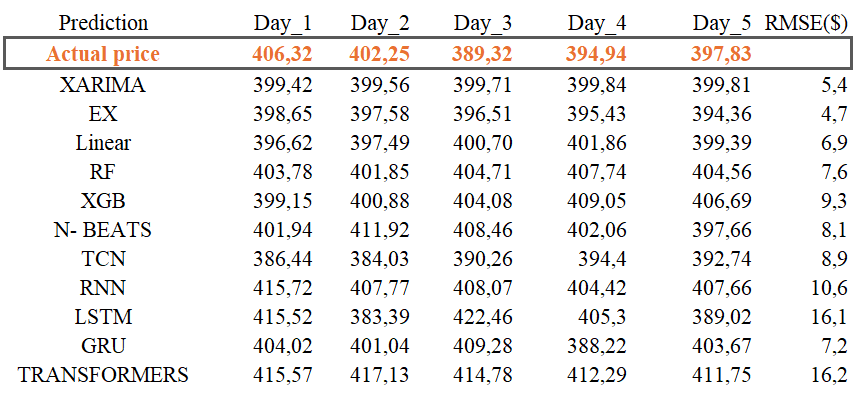

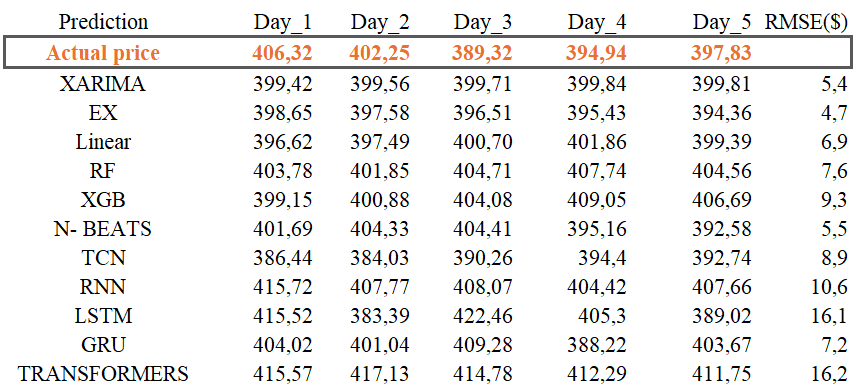

### N-beats and TCN with covariates (Technical, Fundamental, and Sentimental data)

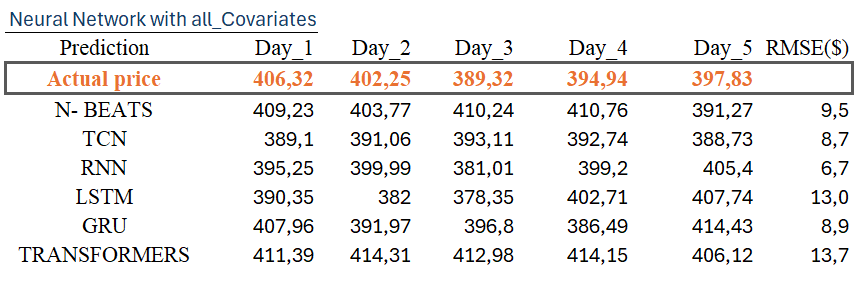

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import math

# reddit news import
import praw

# sentimental analysis
from textblob import TextBlob 

import darts
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller
from darts.dataprocessing.transformers import Scaler
from darts import concatenate

# model
from darts.models import TCNModel,NBEATSModel,TransformerModel,BlockRNNModel
# darts model evaluation
from darts.metrics import mape, rmse, r2_score

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
The statsforecast module could not be imported. To enable support for the StatsForecastAutoARIMA, StatsForecastAutoETS and Croston models, please consider installing it.


In [2]:
# import data from previous worked file
df = pd.read_csv(r"C:\Users\dicod\Documents\2024\project_with Hamid(2024_3rd semester)\Scientific Project\Data\df_sentiment.csv")
df = df[['Date','Title']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    324 non-null    object
 1   Title   324 non-null    object
dtypes: object(2)
memory usage: 5.2+ KB


In [3]:
# define seti func
def sentiment_analysis(title):
    blob = TextBlob(title)
    sentiment_score = blob.sentiment.polarity  
    if sentiment_score > 0: 
        return 1  # positive
    elif sentiment_score == 0: 
        return 0  # netural
    else:
        return -1  # negative

df['Sentiment_Score'] = df['Title'].apply(sentiment_analysis)

# result
df

,Date,Title,Sentiment_Score
0,2024-03-20,"Who is Mustafa Suleyman, the new AI chief at M...",1
1,2024-03-22,Microsoft’s $650 million deal with Inflection ...,0
2,2024-03-25,The second coming of the Microsoft antitrust b...,0
3,2024-03-27,IIT Madras alumnus Pavan Davuluri appointed Mi...,0
4,2024-03-30,US Congress bans staff use of Microsoft's AI C...,0
...,...,...,...
319,2024-04-26,Performing an automated Google Workspace migra...,0
320,2024-04-26,Any way?,0
321,2024-04-26,Is there way to change the font size of Bing's...,0
322,2024-04-26,HELP! Do I need to worry about hire to fire as...,1


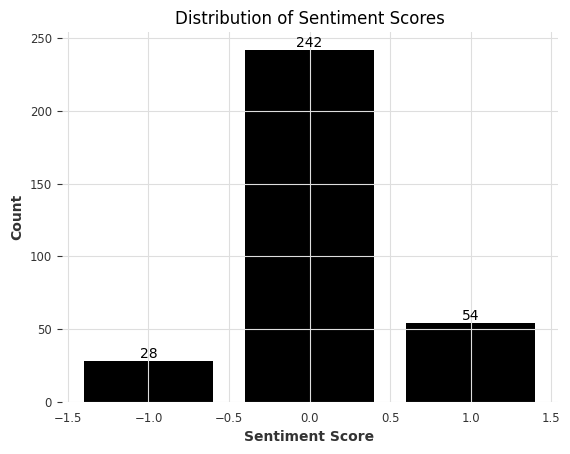

In [4]:
# Count the number of positive and negative sentiment scores
sentiment_counts = df['Sentiment_Score'].value_counts()

# Plot a bar chart
plt.bar(sentiment_counts.index, sentiment_counts.values)

# Add labels and title
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Scores')

# Add text labels
for i, count in enumerate(sentiment_counts.values):
    plt.text(sentiment_counts.index[i], count, str(count), ha='center', va='bottom')

# Show the plot
plt.show()

In [5]:
average_scores = df.groupby('Date')['Sentiment_Score'].mean()

In [6]:
df_average_scores = pd.DataFrame(average_scores)
df_average_scores.reset_index(inplace=True)
df_average_scores.head()

,Date,Sentiment_Score
0,2024-03-20,1.00
1,2024-03-22,0.00
2,2024-03-25,0.00
3,2024-03-27,0.00
4,2024-03-30,-0.25


In [7]:
df_average_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             29 non-null     object 
 1   Sentiment_Score  29 non-null     float64
dtypes: float64(1), object(1)
memory usage: 596.0+ bytes


In [8]:
df_average_scores['Date'] = pd.to_datetime(df_average_scores['Date'])

In [9]:
msft = yf.Ticker("MSFT")
historical_data = msft.history(start="2024-03-20", end ="2024-04-26")
historical_data.index = historical_data.index.tz_convert(None)
historical_data.reset_index(inplace=True)
h_df = historical_data[['Date', 'Close', 'Volume']]
h_df.head()

,Date,Close,Volume
0,2024-03-20 04:00:00,424.464386,17860100
1,2024-03-21 04:00:00,428.596924,21296200
2,2024-03-22 04:00:00,427.968048,17636500
3,2024-03-25 04:00:00,422.098633,18060500
4,2024-03-26 04:00:00,420.890808,16725600


In [10]:
# create a list of our conditions
conditions = [
    (h_df['Date'] < '2020-07-01 04:00:00'),
    (h_df['Date'] >= '2020-07-01 04:00:00') & (h_df['Date'] < '2021-07-01 04:00:00'),
    (h_df['Date'] >= '2021-07-01 04:00:00') & (h_df['Date'] < '2022-07-01 04:00:00'),
    (h_df['Date'] >= '2022-07-01 04:00:00') & (h_df['Date'] < '2023-07-01 04:00:00'),
    (h_df['Date'] >= '2023-07-01 04:00:00') 
    ]

# create a list of the values we want to assign for each condition
values = [5.82, 8.12, 9.70, 9.72, 10.37] # 10.37 is TTM

# create a new column and use np.select to assign values to it using our lists as arguments
h_df['EPS'] = np.select(conditions, values)

# create a list of our conditions
conditions = [
    (h_df['Date'] < '2020-07-01 04:00:00'),
    (h_df['Date'] >= '2020-07-01 04:00:00') & (h_df['Date'] < '2021-07-01 04:00:00'),
    (h_df['Date'] >= '2021-07-01 04:00:00') & (h_df['Date'] < '2022-07-01 04:00:00'),
    (h_df['Date'] >= '2022-07-01 04:00:00') & (h_df['Date'] < '2023-07-01 04:00:00'),
    (h_df['Date'] >= '2023-07-01 04:00:00') 
    ]

# create a list of the values we want to assign for each condition
values = [143015000000.0, 168088000000.0, 198270000000.0, 211915000000.0, 227583000] # 227583000 is TTM.

# create a new column
h_df['Total Revenue'] = np.select(conditions, values)

h_df.loc[:,'P/E'] = h_df['Close']/h_df['EPS']
h_df.loc[:,'P/S'] = h_df['Close']/h_df['Total Revenue']

h_df['Date'] = pd.to_datetime(h_df['Date'])
h_df['Date'] = h_df['Date'].dt.strftime('%Y-%m-%d')
h_df['Date'] = h_df['Date'].apply(lambda x:x[0:10])
h_df['Date'] = pd.to_datetime(h_df['Date'])

C:\Users\dicod\AppData\Local\Temp\ipykernel_21768\2094565912.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_df['EPS'] = np.select(conditions, values)
C:\Users\dicod\AppData\Local\Temp\ipykernel_21768\2094565912.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_df['Total Revenue'] = np.select(conditions, values)
C:\Users\dicod\AppData\Local\Temp\ipykernel_21768\2094565912.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [11]:
h_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           26 non-null     datetime64[ns]
 1   Close          26 non-null     float64       
 2   Volume         26 non-null     int64         
 3   EPS            26 non-null     float64       
 4   Total Revenue  26 non-null     float64       
 5   P/E            26 non-null     float64       
 6   P/S            26 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 1.6 KB


In [12]:
df_st = pd.merge(h_df, df_average_scores, on='Date', how='left')
df_st

,Date,Close,Volume,EPS,Total Revenue,P/E,P/S,Sentiment_Score
0,2024-03-20,424.464386,17860100,10.37,227583000.0,40.931956,0.000002,1.000000
1,2024-03-21,428.596924,21296200,10.37,227583000.0,41.330465,0.000002,NaN
2,2024-03-22,427.968048,17636500,10.37,227583000.0,41.269821,0.000002,0.000000
3,2024-03-25,422.098633,18060500,10.37,227583000.0,40.703822,0.000002,0.000000
4,2024-03-26,420.890808,16725600,10.37,227583000.0,40.587349,0.000002,NaN
5,2024-03-27,420.671204,16705000,10.37,227583000.0,40.566172,0.000002,0.000000
6,2024-03-28,419.962494,21871200,10.37,227583000.0,40.497830,0.000002,NaN
7,2024-04-01,423.805573,16316000,10.37,227583000.0,40.868426,0.000002,0.000000
8,2024-04-02,420.681213,17912000,10.37,227583000.0,40.567137,0.000002,NaN
9,2024-04-03,419.692993,16502300,10.37,227583000.0,40.471841,0.000002,0.000000


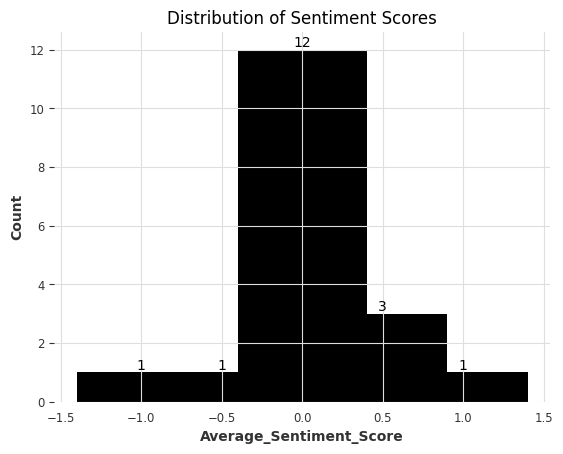

In [13]:
df_st['Sentiment_Score'].fillna(0.0, inplace=True)

sentiment_counts = df_st['Sentiment_Score'].value_counts()

# Plot a bar chart
plt.bar(sentiment_counts.index, sentiment_counts.values)

# Add labels and title
plt.xlabel('Average_Sentiment_Score')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Scores')

# Add text labels
for i, count in enumerate(sentiment_counts.values):
    plt.text(sentiment_counts.index[i], count, str(count), ha='center', va='bottom')

# Show the plot
plt.show()

In [14]:
df_st.reset_index(inplace=True)

In [15]:
df_st

,index,Date,Close,Volume,EPS,Total Revenue,P/E,P/S,Sentiment_Score
0,0,2024-03-20,425.230011,17860100,10.37,227583000.0,41.005787,0.000002,1.000000
1,1,2024-03-21,429.369995,21296200,10.37,227583000.0,41.405014,0.000002,0.000000
2,2,2024-03-22,428.739990,17636500,10.37,227583000.0,41.344261,0.000002,0.000000
3,3,2024-03-25,422.859985,18060500,10.37,227583000.0,40.777241,0.000002,0.000000
4,4,2024-03-26,421.649994,16725600,10.37,227583000.0,40.660559,0.000002,0.000000
5,5,2024-03-27,421.429993,16705000,10.37,227583000.0,40.639344,0.000002,0.000000
6,6,2024-03-28,420.720001,21871200,10.37,227583000.0,40.570878,0.000002,0.000000
7,7,2024-04-01,424.570007,16316000,10.37,227583000.0,40.942141,0.000002,0.000000
8,8,2024-04-02,421.440002,17912000,10.37,227583000.0,40.640309,0.000002,0.000000
9,9,2024-04-03,420.450012,16502300,10.37,227583000.0,40.544842,0.000002,0.000000


In [15]:
# dataframe to timeseries
ts_price = TimeSeries.from_dataframe(df_st, time_col=None, value_cols='Close', fill_missing_dates=False, freq='D')
ts_Volume = TimeSeries.from_dataframe(df_st, time_col=None, value_cols='Volume', fill_missing_dates=False, freq='D')
ts_EPS = TimeSeries.from_dataframe(df_st, time_col=None, value_cols='EPS', fill_missing_dates=False, freq='D')
ts_PE = TimeSeries.from_dataframe(df_st, time_col=None, value_cols='P/E', fill_missing_dates=False, freq='D')
ts_PS = TimeSeries.from_dataframe(df_st, time_col=None, value_cols='P/S', fill_missing_dates=False, freq='D')
ts_ST = TimeSeries.from_dataframe(df_st, time_col=None, value_cols='Sentiment_Score', fill_missing_dates=False, freq='D')

# Missing value fillin
transformer = MissingValuesFiller()

ts_price = transformer.transform(ts_price)
ts_Volume = transformer.transform(ts_Volume)
ts_EPS = transformer.transform(ts_EPS)
ts_PE = transformer.transform(ts_PE)
ts_PS = transformer.transform(ts_PS)
ts_ST = transformer.transform(ts_ST)

# scaler
scaler = Scaler()
scaled_price, scaled_Volume, scaled_EPS, scaled_PE, scaled_PS, scaled_ST = scaler.fit_transform([ts_price, ts_Volume, ts_EPS, ts_PE, ts_PS, ts_ST] )

# concate
my_multivariate_series = concatenate([scaled_price, scaled_Volume, scaled_EPS, scaled_PE, scaled_PS, scaled_ST], axis=1)


In [16]:
past_cov_all = my_multivariate_series[['Volume','EPS', 'P/E', 'P/S', 'Sentiment_Score']]

In [18]:
#train, test = my_multivariate_series.split_after(0.8)

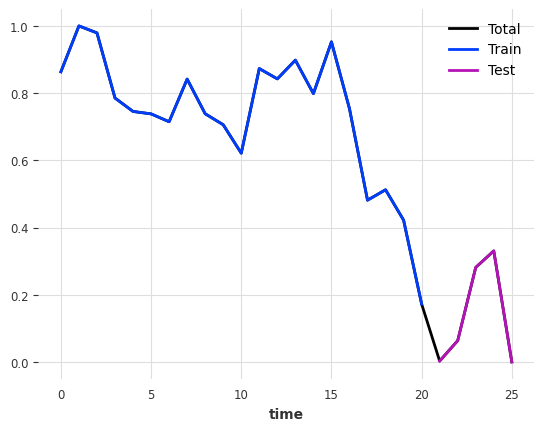

In [19]:
my_multivariate_series['Close'].plot(label='Total')
#train['Close'].plot(label='Train')
#test['Close'].plot(label='Test')

### Model performance with Covariates(sentimental data)

In [17]:
ts_ps = concatenate([scaled_price, scaled_ST], axis=1)
df_st.head()
df_senti = df_st[['Close', 'Sentiment_Score']]
df_senti.reset_index(inplace = True)

In [21]:
df_senti.head()

,time,Close,Sentiment_Score
0,0,425.230011,1.0
1,1,429.369995,0.0
2,2,428.739990,0.0
3,3,422.859985,0.0
4,4,421.649994,0.0


### Statistical model
1. Ariam, we add x variables with sentimental data, so we will use xarima.
2. Exponential smoothing 

In [41]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

exog_forecast = df_st[['Volume', 'EPS', 'P/E', 'P/S', 'Sentiment_Score']].iloc[-5:]
print("Exogenous forecast shape:", exog_forecast.shape)  # Should output (5, 5)

# Fit the ARIMA model with exogenous variables
arima_model = ARIMA(endog=df_st['Close'], exog=df_st[['Volume', 'EPS', 'P/E', 'P/S', 'Sentiment_Score']], order=(1, 1, 1))
arima_model_fit = arima_model.fit()

# Forecast with the same exogenous variables shape (5, 5)
arima_predictions = arima_model_fit.forecast(steps=5, exog=exog_forecast)
print("ARIMA predictions:", arima_predictions)
df_arima = arima_predictions


Exogenous forecast shape: (5, 5)
ARIMA predictions: 26    398.401398
27    400.238068
28    406.836182
29    408.323486
30    398.321533
Name: predicted_mean, dtype: float64


c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [44]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# 1. Arima
arima_model = ARIMA(endog=df_st['Close'], exog=df_st['Sentiment_Score'], order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_predictions = arima_model_fit.forecast(steps=5, exog=df_st['Sentiment_Score'].iloc[-5:].values.reshape(-1, 1))
print("ARIMA predictions:", arima_predictions)
df_arima = arima_predictions.reset_index()
df_arima.columns = ['index', 'predicted_value']
df_arima

ARIMA predictions: 26    399.427097
27    399.569758
28    399.711701
29    399.842946
30    399.810765
Name: predicted_mean, dtype: float64


,index,predicted_value
0,26,399.427097
1,27,399.569758
2,28,399.711701
3,29,399.842946
4,30,399.810765


In [62]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# 1. Arima
arima_model = ARIMA(endog=df_st['Close'], exog=df_st['Sentiment_Score'], order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_predictions = arima_model_fit.forecast(steps=5, exog=df_st['Sentiment_Score'].iloc[-5:].values.reshape(-1, 1))
print("ARIMA predictions:", arima_predictions)
df_arima = arima_predictions.reset_index()
df_arima.columns = ['index', 'arima_pred']
df_arima

# 2. Exponential model
exponential_model = ExponentialSmoothing(df_st['Close'] + df_st['Sentiment_Score'], trend='add')
exponential_model_fit = exponential_model.fit()
exponential_predictions = exponential_model_fit.forecast(5)
df_ex = exponential_predictions.reset_index()
df_ex.columns = ['index', 'ex_pred']
df_ex

ARIMA predictions: 26    399.427097
27    399.569758
28    399.711701
29    399.842946
30    399.810765
Name: predicted_mean, dtype: float64


,index,ex_pred
0,26,398.654463
1,27,397.582026
2,28,396.509589
3,29,395.437152
4,30,394.364715


# Machine Learning Model

1. Linear Regression
2. Random Forest
3. XGB Boost 

In [73]:
# 1. linear Regression

past_cov= my_multivariate_series['Sentiment_Score']
from darts.models import LinearRegressionModel
model = LinearRegressionModel(
    lags=1,
    lags_past_covariates=1,
    output_chunk_length=5,
)
model.fit(ts_ps['Close'], past_covariates=past_cov)
pred = model.predict(5)
pred_price = scaler.inverse_transform(pred)
pred_price

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[396.62102037]],

       [[397.49560588]],

       [[400.70324192]],

       [[401.86147818]],

       [[399.39957857]]])
Coordinates:
  * time       (time) int64 26 27 28 29 30
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [35]:
# 2. Random Forest
from darts.models import RandomForest

model = RandomForest(
    lags=1,
    lags_past_covariates=1,
    output_chunk_length=5,
    n_estimators=100,
    criterion="absolute_error",
)
model.fit(ts_ps['Close'], past_covariates=past_cov)
pred = model.predict(5)
pred_price = scaler.inverse_transform(pred)
pred_price.values()

array([[403.78299225],
       [401.85579346],
       [404.71119781],
       [407.74140198],
       [404.56500122]])

In [36]:
# 3. XGBModel
from darts.models import XGBModel

model = XGBModel(
    lags=1,
    lags_past_covariates=1,
    output_chunk_length=5,
)
model.fit(ts_ps['Close'], past_covariates=past_cov)
pred = model.predict(5)
pred_price = scaler.inverse_transform(pred)
pred_price.values()

array([[399.1509 ],
       [400.8875 ],
       [404.08536],
       [409.05106],
       [406.69824]], dtype=float32)

# Neural Network Model

1. N beats
2. TCN
3. RNN
4. LSTM
5. GRU
6. TRANSFORMERS

In [18]:

past_cov= my_multivariate_series['Sentiment_Score']


In [39]:
# N-BEATS

model_par_3 = NBEATSModel(
    input_chunk_length=8,
    output_chunk_length=5,
    generic_architecture=True, num_stacks=2, num_blocks=4, num_layers=2,
    n_epochs=30,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_3.fit(ts_ps['Close'], past_covariates=past_cov)
pred_series = model_par_3.predict(5)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
pred_price


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 582 K 
---------------------------------------------------
581 K     Trainable params
1.4 K     Non-trainable params
582 K     Total params
2.332     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[401.94708881]],

       [[411.92380562]],

       [[408.46003542]],

       [[402.06487131]],

       [[397.66219316]]])
Coordinates:
  * time       (time) int64 26 27 28 29 30
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [31]:
# TCN
TCN_par4 = TCNModel(
    input_chunk_length=8,
    output_chunk_length=5,
    kernel_size=2, num_filters=2, num_layers=3, weight_norm=True,
    n_epochs=30, random_state=42
)
# total 
TCN_par4.fit(ts_ps['Close'], past_covariates=past_cov)

TCN_par4_pred_series = TCN_par4.predict(5)

pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
pred_price

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 69    
----------------------------------------------------
69        Trainable params
0         Non-trainable params
69        Total params
0.000     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[386.44914056]],

       [[384.03649   ]],

       [[390.26403192]],

       [[394.40090303]],

       [[392.74213022]]])
Coordinates:
  * time       (time) int64 26 27 28 29 30
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [23]:
# RNN
rnn_3 = BlockRNNModel(
    input_chunk_length=8,
    output_chunk_length=5,
    model ="RNN",
    hidden_dim=2,
    n_rnn_layers=3,
    n_epochs=30,
    random_state=42)


# total
rnn_3.fit(ts_ps['Close'], past_covariates=past_cov)
pred_price = scaler.inverse_transform(rnn_3.predict(5))
pred_price

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 36    
4 | fc            | Sequential       | 15    
---------------------------------------------------
51        Trainable params
0         Non-trainable params
51        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[415.72532449]],

       [[407.77987888]],

       [[408.07125737]],

       [[404.4219106 ]],

       [[407.66575909]]])
Coordinates:
  * time       (time) int64 26 27 28 29 30
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [24]:
# LSTM
LSTM = BlockRNNModel(
    input_chunk_length=8,
    output_chunk_length=5,
    model ="LSTM",
    hidden_dim=2,
    n_rnn_layers=3,
    n_epochs=30,
    random_state=42)


# total
LSTM.fit(ts_ps['Close'], past_covariates=past_cov)
pred_price = scaler.inverse_transform(LSTM.predict(5))
pred_price

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 144   
4 | fc            | Sequential       | 15    
---------------------------------------------------
159       Trainable params
0         Non-trainable params
159       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[415.5276889 ]],

       [[383.39739173]],

       [[422.46064162]],

       [[405.30932575]],

       [[389.02167587]]])
Coordinates:
  * time       (time) int64 26 27 28 29 30
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [25]:
# GRU
GRU = BlockRNNModel(
    input_chunk_length=8,
    output_chunk_length=5,
    model ="GRU",
    hidden_dim=2,
    n_rnn_layers=3,
    n_epochs=30,
    random_state=42)


# total
GRU.fit(ts_ps['Close'], past_covariates=past_cov)
pred_price = scaler.inverse_transform(GRU.predict(5))
pred_price

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 108   
4 | fc            | Sequential       | 15    
---------------------------------------------------
123       Trainable params
0         Non-trainable params
123       Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[404.02117688]],

       [[401.04235205]],

       [[409.28086555]],

       [[388.22353573]],

       [[403.67051486]]])
Coordinates:
  * time       (time) int64 26 27 28 29 30
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [26]:
transformers = TransformerModel(
    input_chunk_length=8,
    output_chunk_length=5,
    d_model=8, nhead=4, num_encoder_layers=3, num_decoder_layers=3,
    n_epochs=30, random_state=42)

# total

transformers.fit(ts_ps['Close'], past_covariates=past_cov)
pred_price = scaler.inverse_transform(transformers.predict(5))
pred_price


c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 24    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer     

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[415.57673303]],

       [[417.13085187]],

       [[414.78768586]],

       [[412.29086517]],

       [[411.75961406]]])
Coordinates:
  * time       (time) int64 26 27 28 29 30
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [76]:
# Actual Value import from Yahoo finance
msft = yf.Ticker("MSFT")
historical_data = msft.history(start="2024-04-26", end ="2024-05-03")
historical_data
#h_df = historical_data[['Date', 'Close']]
#h_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-04-26 00:00:00-04:00,412.170013,413.000000,405.760010,406.320007,29694700,0.0,0.0
2024-04-29 00:00:00-04:00,405.250000,406.320007,399.190002,402.250000,19582100,0.0,0.0
2024-04-30 00:00:00-04:00,401.489990,402.160004,389.170013,389.329987,28781400,0.0,0.0
2024-05-01 00:00:00-04:00,392.609985,401.720001,390.309998,394.940002,23562500,0.0,0.0
2024-05-02 00:00:00-04:00,397.660004,399.929993,394.649994,397.839996,17709400,0.0,0.0


# Neural Network Model with All_Covariates

In [38]:
# N-BEATS

model_par_3 = NBEATSModel(
    input_chunk_length=8,
    output_chunk_length=5,
    generic_architecture=True, num_stacks=2, num_blocks=4, num_layers=2,
    n_epochs=30,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_3.fit(my_multivariate_series['Close'], past_covariates=past_cov_all)
pred_series = model_par_3.predict(5)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
pred_price

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 650 K 
---------------------------------------------------
649 K     Trainable params
1.6 K     Non-trainable params
650 K     Total params
2.604     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[409.23572555]],

       [[403.77186831]],

       [[410.24547505]],

       [[410.76120084]],

       [[391.27156656]]])
Coordinates:
  * time       (time) int64 26 27 28 29 30
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [33]:
# TCN
TCN_par4 = TCNModel(
    input_chunk_length=8,
    output_chunk_length=5,
    kernel_size=2, num_filters=2, num_layers=3, weight_norm=True,
    n_epochs=30, random_state=42
)
# total 
TCN_par4.fit(my_multivariate_series['Close'], past_covariates=past_cov_all)

TCN_par4_pred_series = TCN_par4.predict(5)

pred_price = scaler.inverse_transform(TCN_par4_pred_series['Close'])
pred_price

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 99    
----------------------------------------------------
99        Trainable params
0         Non-trainable params
99        Total params
0.000     Total estimated model params size (MB)

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[389.10753049]],

       [[391.0635863 ]],

       [[393.11308475]],

       [[392.74895937]],

       [[388.7384982 ]]])
Coordinates:
  * time       (time) int64 26 27 28 29 30
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [34]:
# RNN
rnn_3 = BlockRNNModel(
    input_chunk_length=8,
    output_chunk_length=5,
    model ="RNN",
    hidden_dim=2,
    n_rnn_layers=3,
    n_epochs=30,
    random_state=42)


# total
rnn_3.fit(my_multivariate_series['Close'], past_covariates=past_cov_all)
pred_price = scaler.inverse_transform(rnn_3.predict(5))
pred_price

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 44    
4 | fc            | Sequential       | 15    
---------------------------------------------------
59        Trainable params
0         Non-trainable params
59        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[395.25756066]],

       [[399.99782066]],

       [[381.01035121]],

       [[399.20921527]],

       [[405.40573408]]])
Coordinates:
  * time       (time) int64 26 27 28 29 30
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [35]:
# LSTM
LSTM = BlockRNNModel(
    input_chunk_length=8,
    output_chunk_length=5,
    model ="LSTM",
    hidden_dim=2,
    n_rnn_layers=3,
    n_epochs=30,
    random_state=42)


# total
LSTM.fit(my_multivariate_series['Close'], past_covariates=past_cov_all)
pred_price = scaler.inverse_transform(LSTM.predict(5))
pred_price

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 176   
4 | fc            | Sequential       | 15    
---------------------------------------------------
191       Trainable params
0         Non-trainable params
191       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[390.35150992]],

       [[382.00002766]],

       [[378.35064038]],

       [[402.71179481]],

       [[407.74250165]]])
Coordinates:
  * time       (time) int64 26 27 28 29 30
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [36]:
# GRU
GRU = BlockRNNModel(
    input_chunk_length=8,
    output_chunk_length=5,
    model ="GRU",
    hidden_dim=2,
    n_rnn_layers=3,
    n_epochs=30,
    random_state=42)


# total
GRU.fit(my_multivariate_series['Close'], past_covariates=past_cov_all)
pred_price = scaler.inverse_transform(GRU.predict(5))
pred_price

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 132   
4 | fc            | Sequential       | 15    
---------------------------------------------------
147       Trainable params
0         Non-trainable params
147       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[407.96589163]],

       [[391.97379003]],

       [[396.80270504]],

       [[386.492624  ]],

       [[414.43804449]]])
Coordinates:
  * time       (time) int64 26 27 28 29 30
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [37]:
transformers = TransformerModel(
    input_chunk_length=8,
    output_chunk_length=5,
    d_model=8, nhead=4, num_encoder_layers=3, num_decoder_layers=3,
    n_epochs=30, random_state=42)

# total

transformers.fit(my_multivariate_series['Close'], past_covariates=past_cov_all)
pred_price = scaler.inverse_transform(transformers.predict(5))
pred_price

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 56    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer     

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[411.39703817]],

       [[414.31170902]],

       [[412.985214  ]],

       [[414.15766459]],

       [[406.12980214]]])
Coordinates:
  * time       (time) int64 26 27 28 29 30
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None